In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

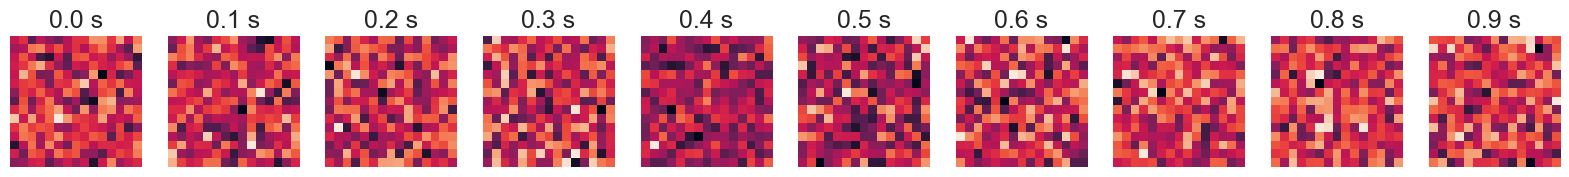

In [2]:
duration = 50.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))


S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

# plot the first second of stimuli
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(S[i])
    plt.axis('off')
    plt.title(f'0.{i} s')


Text(0, 0.5, 'y')

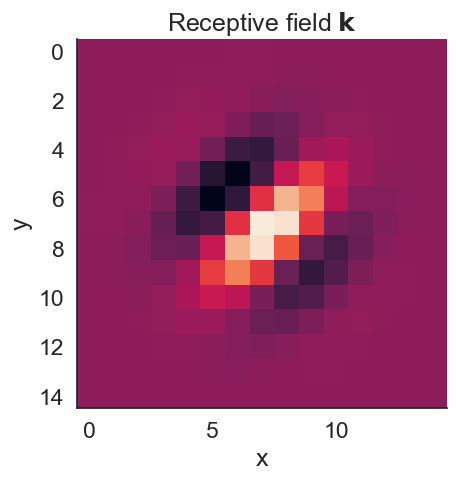

In [3]:
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.xlabel('x')
plt.ylabel('y')

In [4]:
noise_variance = 1
offset = 2.

# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

# 2. nonlinear stage (for a linear model: f -> identity function)
rate = ks

# add Gaussian noise centered around the "true" rate for each bin
rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

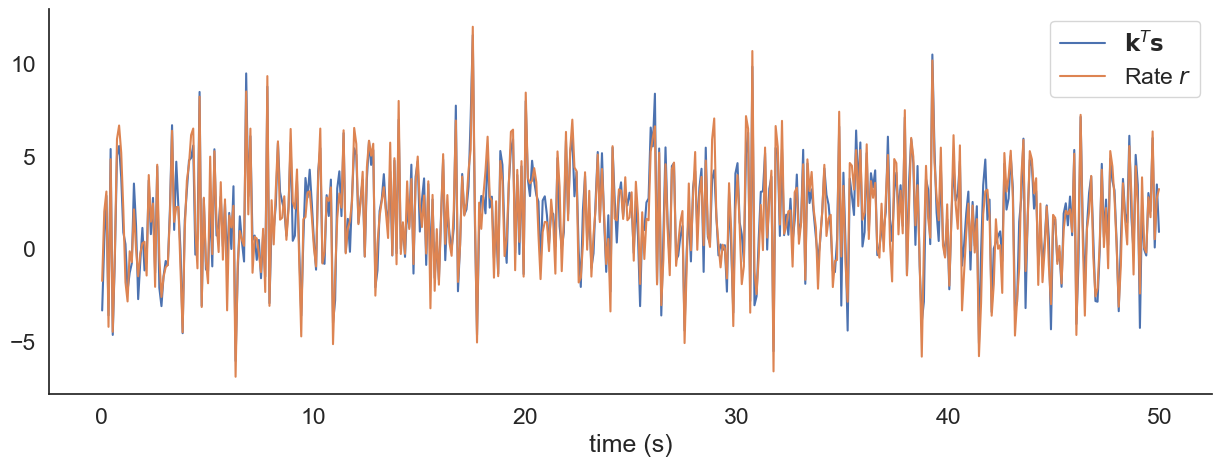

In [5]:
plt.figure(figsize=(15,5))
t = (.5 + np.arange(n_bins)) * dt # bin centers
plt.plot(t, ks, '-',
       label=r'$\mathbf{k}^T\mathbf{s}$')
plt.plot(t, rate, '-',
       label=r'Rate $r$')
plt.xlabel('time (s)')
plt.legend()

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Linear transform (+ Gaussian noise)')
xx = np.linspace(ks.min(), ks.max(), 100)
plt.plot(xx, xx, 'r-') # relationship between input and output
plt.scatter(ks, rate, s=10, c=[3*[.1]])
plt.xlabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.ylabel(r'Rate $r$')

average spike rate: 4.80 spikes per second
Pearson correlation = 0.197
average spike rate: 5.00 spikes per second


C:\Users\Jelle\AppData\Local\Temp\ipykernel_28192\1045822518.py:109: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


Pearson correlation = 0.232
average spike rate: 4.70 spikes per second
Pearson correlation = 0.284
average spike rate: 4.42 spikes per second
Pearson correlation = 0.527
average spike rate: 4.75 spikes per second
Pearson correlation = 0.734
average spike rate: 4.74 spikes per second
Pearson correlation = 0.831
average spike rate: 4.69 spikes per second
Pearson correlation = 0.968
average spike rate: 4.74 spikes per second
Pearson correlation = 0.979


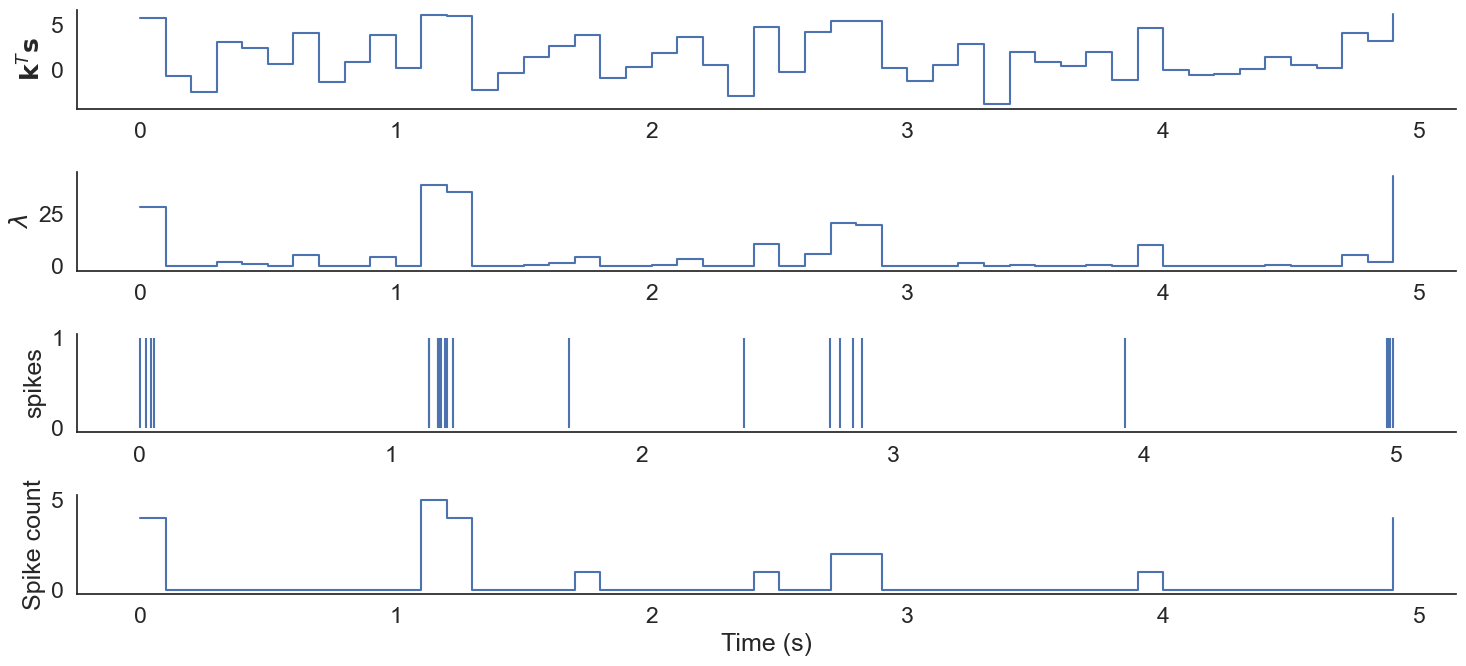

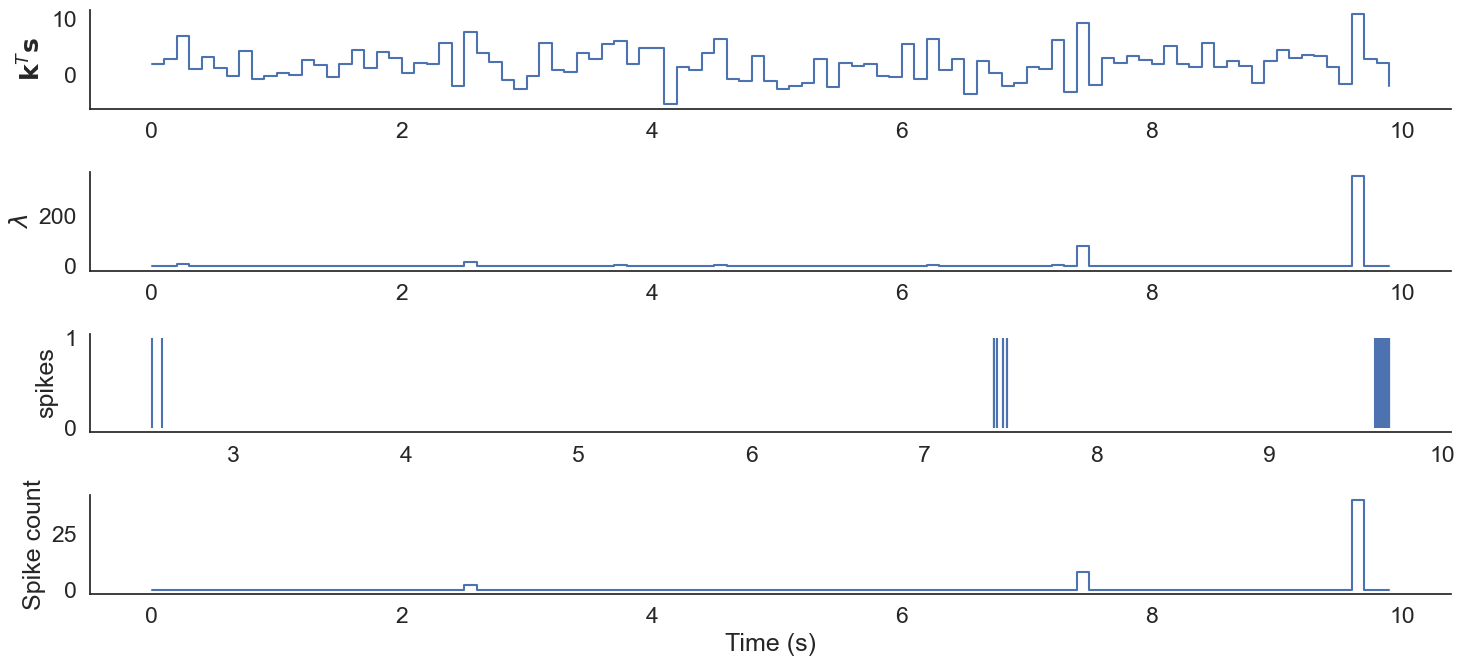

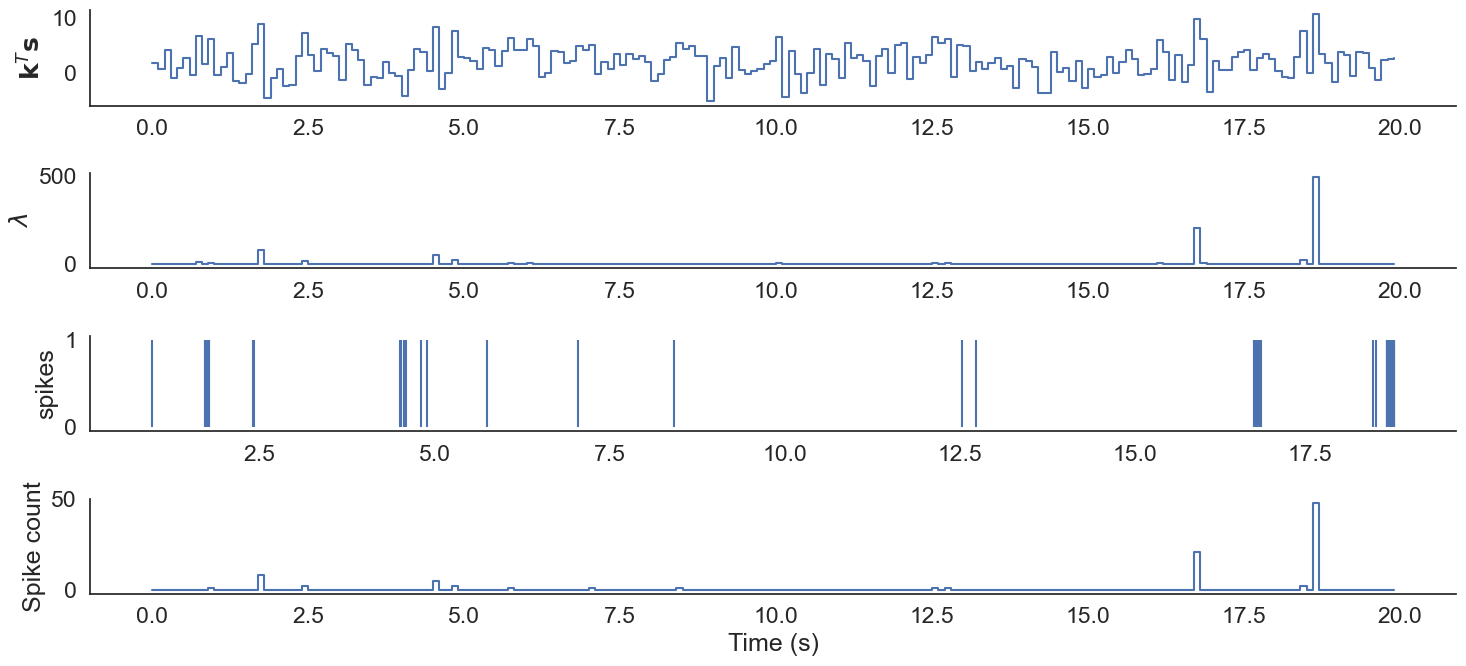

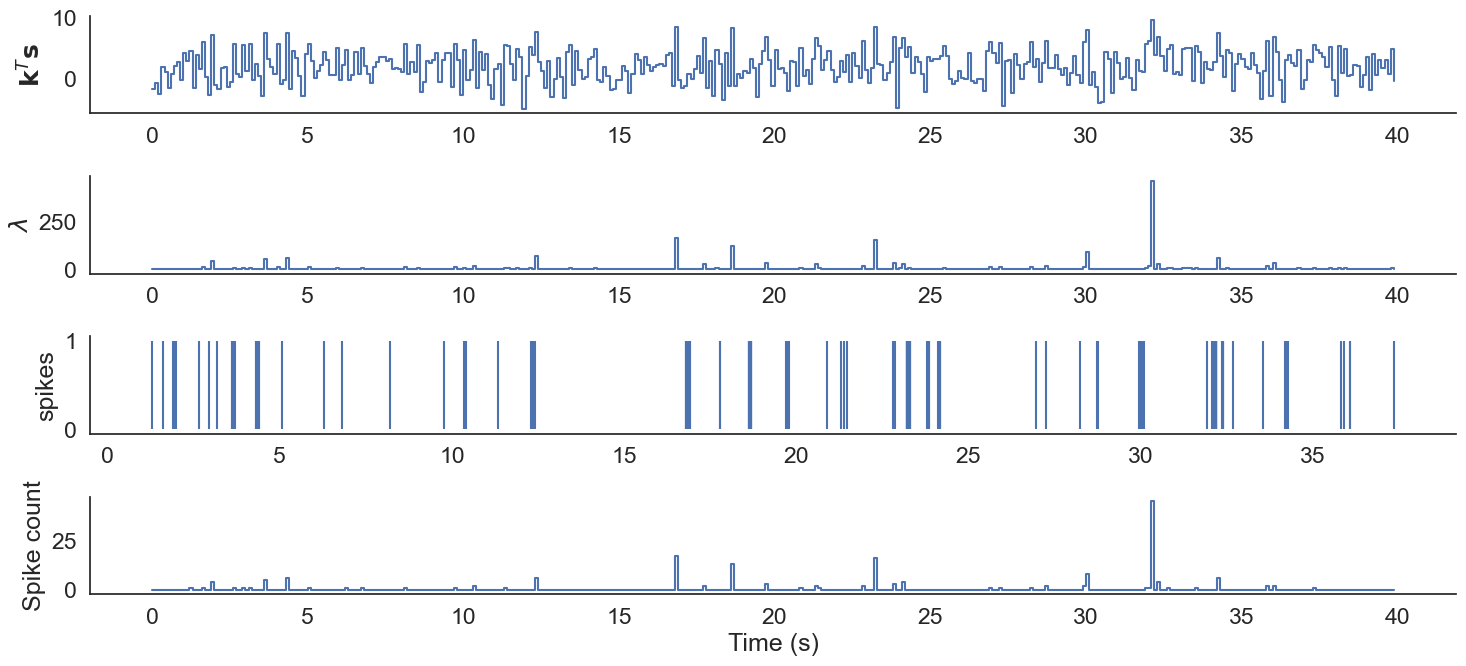

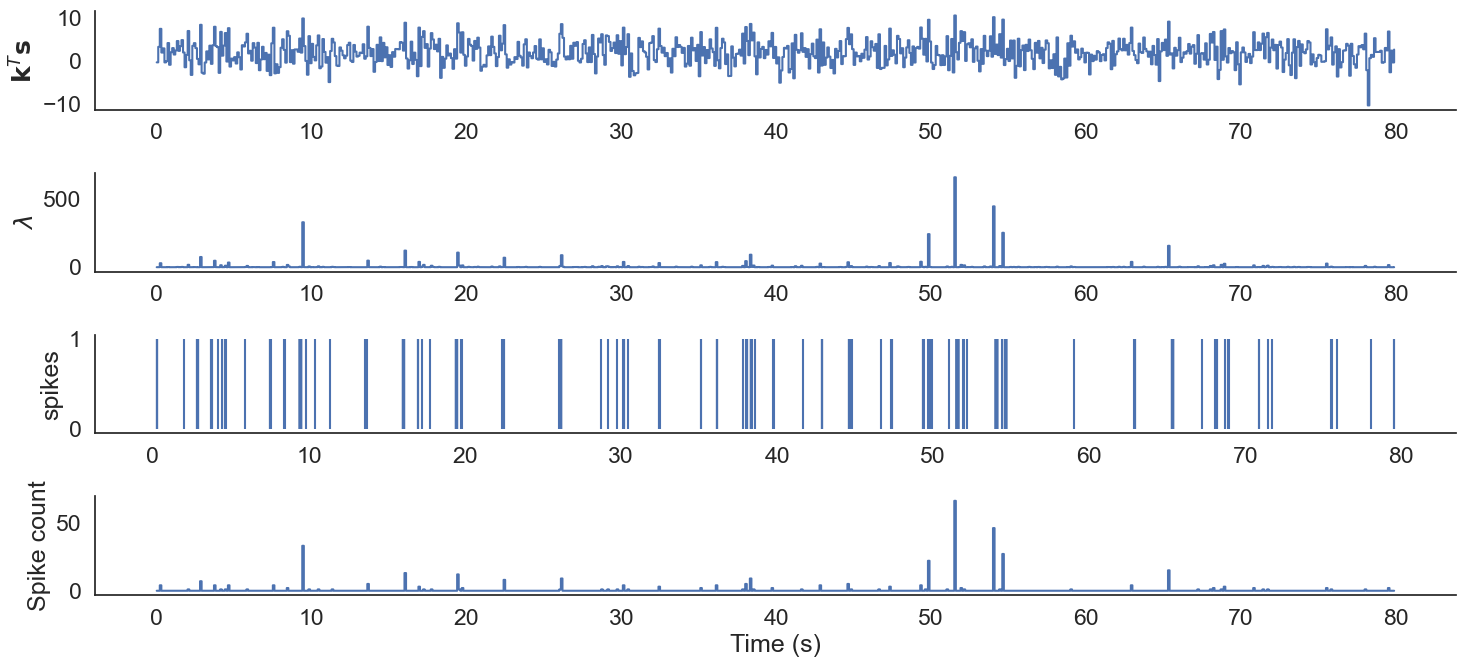

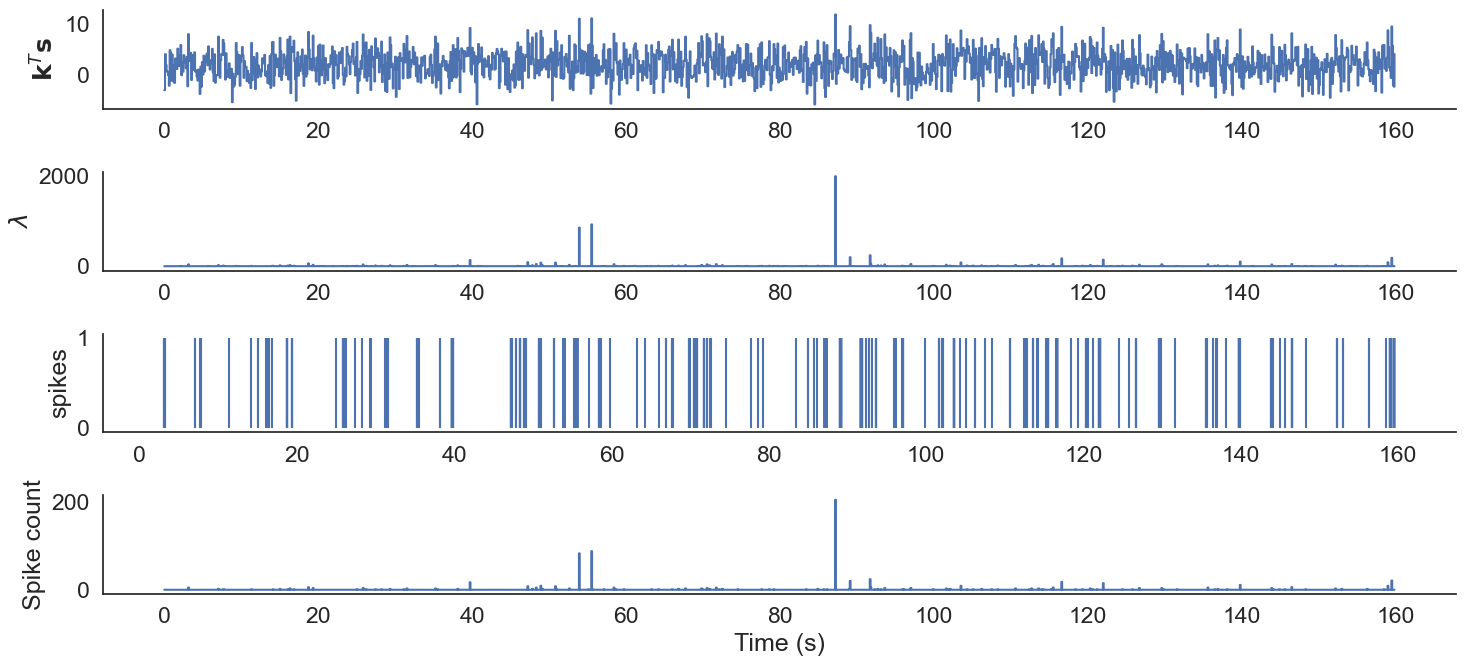

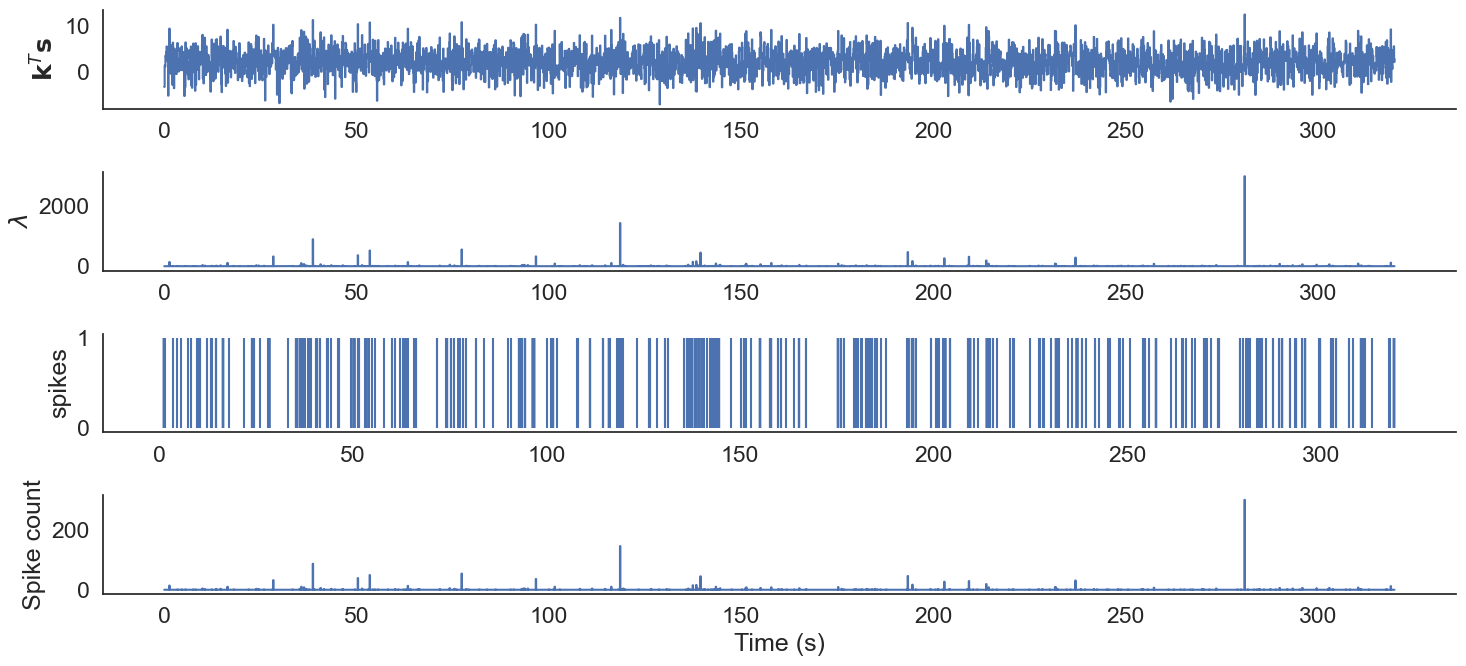

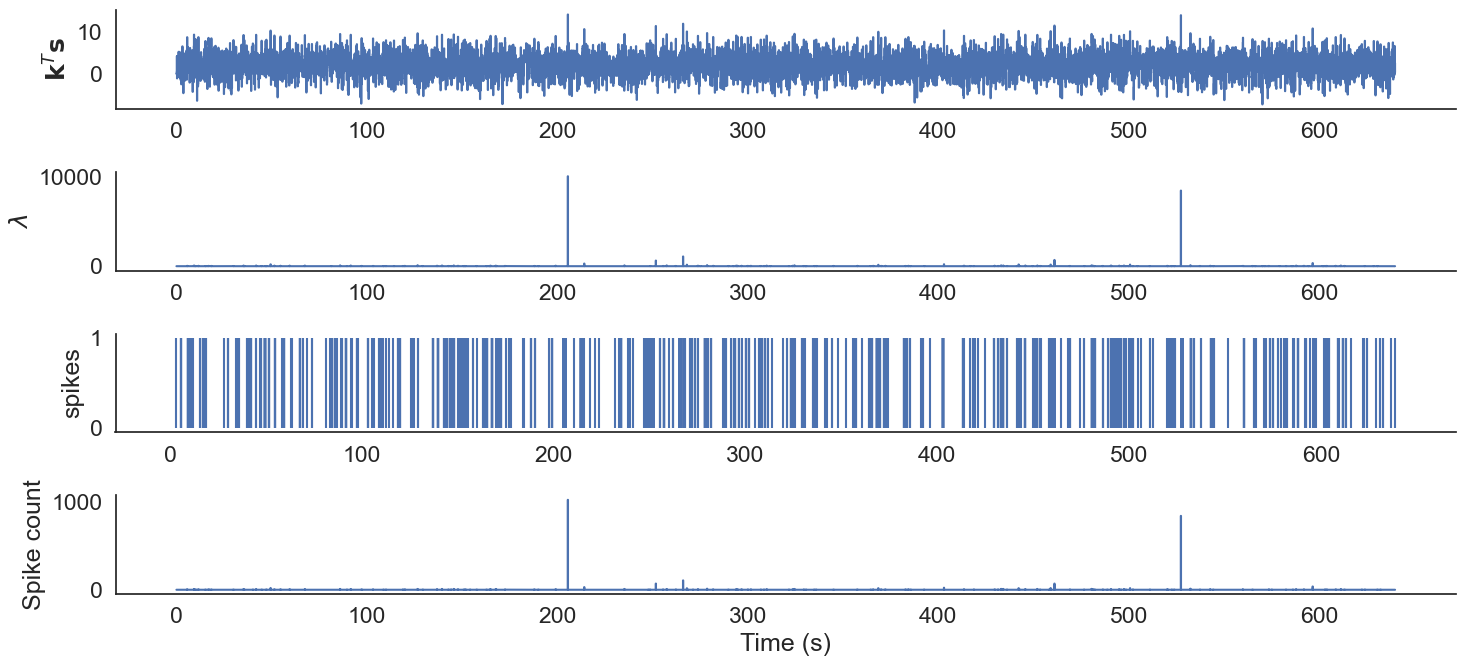

In [13]:
from scipy.optimize import minimize
# genration of the stimuli sequences with different durations
durations = [5, 10, 20, 40, 80, 160, 320, 640]
for duration in durations:
    dt = .1
    std_dev = 1
    vf_size = (15,15)
    n_bins = round(duration / float(dt))


    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

    def generate_inhomogeneous_poisson_spikes(lamda, dt):
    
        n_bins = lamda.shape[0]
        bins = np.arange(n_bins+1)*dt
    
        # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
        lamda_max = np.max(lamda)
        poisson_numbers = np.random.poisson(lamda_max, size=n_bins)
    
        # throw away numbers depending on the actual intensity ("thinning")
        spike_times = []
        prob = lamda / lamda_max
        for i in range(n_bins):
            
            # number of spikes to keep in this bin
            n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
            n_s = int(round(n * dt))
    
            # generate random spike times in this bin
            ts = bins[i] + np.random.rand(n_s)*dt
    
            spike_times.extend(ts)
    
        return np.asarray(spike_times)

    spike_rate = 5 # average firing rate 
    
    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))
    
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
    
    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)
    
    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)
    
    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    
    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    
    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    
    print("average spike rate: %0.2f spikes per second" % (len(spike_times) / duration))

    # Show response
    
    plt.figure(figsize=(15,7))
    
    n_bins = lamda.shape[0]
    t = np.arange(n_bins) * dt
    
    plt.subplot(4,1,1)
    plt.step(t, ks, where='post')
    plt.ylabel(r'$\mathbf{k}^T \mathbf{s}$')
    
    plt.subplot(4,1,2)
    plt.step(t, lamda, where='post')
    plt.ylabel(r'$\lambda$')
    
    plt.subplot(4,1,3)
    plt.vlines(spike_times, 0, 1)
    plt.ylabel('spikes')
    
    plt.subplot(4,1,4)
    plt.step(t, spike_counts, where='post')
    plt.xlabel('Time (s)')
    plt.ylabel('Spike count')
    
    plt.tight_layout()


    # define functions for minimisation
    def cost(k, spike_counts, S,alpha=1):
        #negative loglikelihood function to minimize
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
        
        
    def grad(k, spike_counts, S):
        # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)
    
        ks = np.dot(k, S.T)
        lamda = np.exp(ks)
        return -np.dot(S.T, spike_counts - dt*lamda)
    
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    
    K_est = res.x
    # print pearson correlation for different stimuli sequence durations
    print("Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))